# The Foraging of Slime Mold

👏In short, we tried to imitate this document following our lab style.


---



# Setup

## Installing Libraries

In [119]:
!pip install matplotlib
!pip install pandas
!pip install seaborn

## Downloading Python Scripts

In [122]:
from os.path import basename, exists

def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve
    local, _ = urlretrieve(url, filename)
    print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

# NumPy数组速查笔记
摘抄ABM Lab里可能用到的东西



## NumPy数组
`list()`创建一个列表

[`numpy.array(object, dtype=None)`](https://numpy.org/doc/stable/reference/generated/numpy.array.html)创建一个NumPy数组类的实例`numpy.ndarray`，数组元素由传参决定
* `dtype=None`默认自动选择合适的数据类型
* `dtype=int8`选择8位整型以节省存储空间
* **操作符**的**操作对象**基本被重载为对NumPy数组的每个元素
* ### 元素数据类型转换
[`array.astype(dtype)`](https://numpy.org/doc/stable/reference/generated/numpy.astype.html#numpy-astype)将NumPy数组的元素转换为指定数据类型，*不改变原数据*

[`numpy.nonzero(array)`](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html)返回NumPy数组中非零元素的**索引数组**构成的元组，按维度的顺序进行分类

* `*`用于解包可迭代对象以获取参数
* `zip(*iterables)`将相同索引位置的解包值打包为元组

[`numpy.shape(array)`](https://numpy.org/doc/stable/reference/generated/numpy.shape.html)NumPy数组特化的`len()`
* `np.shape[1]`或`len(array[0])`: 返回x轴长
* `np.shape[0]`或`len(array)`: 返回y轴长

In [50]:
import numpy as np

x = [[[3, 0, 0], [0, 4, 0], [5, 6, 0]]]
y = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]], dtype=None)
print(type(x))
print(x)

print(type(y))
print(y)
print(np.nonzero(y))
print(*np.nonzero(y))
print(list(zip(*np.nonzero(y))))

print(type(y))
print(y+10)   # + - = 之类的操作符被重载为对数组的每个元素都生效

z = y==0
print(type(z))
print(z.astype('uint8'))
print(z)

<class 'list'>
[[[3, 0, 0], [0, 4, 0], [5, 6, 0]]]
<class 'numpy.ndarray'>
[[3 0 0]
 [0 4 0]
 [5 6 0]]
(array([0, 1, 2, 2]), array([0, 1, 0, 1]))
[0 1 2 2] [0 1 0 1]
[(np.int64(0), np.int64(0)), (np.int64(1), np.int64(1)), (np.int64(2), np.int64(0)), (np.int64(2), np.int64(1))]
<class 'numpy.ndarray'>
[[13 10 10]
 [10 14 10]
 [15 16 10]]
<class 'numpy.ndarray'>
[[0 1 1]
 [1 0 1]
 [0 0 1]]
[[False  True  True]
 [ True False  True]
 [False False  True]]


## 随机数

###概率分布
[`numpy.random.choice(array, size=None, replace=True, p=None)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)从给定的**一维数组**中随机选择数个元素，构建NumPy数组
* `size=(n, m)`二维
* `replace=True`默认允许元素的重复选取
* `p=None`指定了数组中逐元素对应的概率，默认呈均匀分布

In [51]:
choices = np.array([0, 1, 2], dtype=np.int8)    # 8位的0,1,2
probs = [0.2, 0.4, 0.4]

test_array = np.random.choice(choices, (5, 5), p=probs)
test_array

array([[2, 1, 1, 2, 2],
       [2, 0, 2, 2, 0],
       [1, 2, 1, 1, 2],
       [0, 2, 0, 0, 1],
       [1, 1, 0, 2, 1]], dtype=int8)

### 乱序
[`numpy.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)沿着多位数组的第一个轴对数据进行打乱，子数组的顺序发生改变

In [52]:
ls = list(range(10))
np.random.shuffle(ls)
print(ls)

arr = np.arange(10)
np.random.shuffle(arr)
arr

[4, 1, 7, 3, 5, 9, 8, 6, 2, 0]


array([5, 7, 1, 3, 4, 6, 8, 2, 0, 9])

## 互相关 Cross-Correlation
原理见CA Lab 1-2

In [53]:
from scipy.signal import correlate2d

options = dict(mode='same', boundary='wrap')
kernel = np.array([[1, 1, 1],
          [1, 0, 1],
          [1, 1, 1]], dtype=np.int8)         # cross-correlation基于位置求积的和
# count the number of red neighbours
correlate2d(test_array, kernel, **options)            # **将dict解包为关键字参数
correlate2d(test_array, kernel, mode='same', boundary='wrap')  # 等价写法

ModuleNotFoundError: No module named 'scipy'

## 可视化的主题色

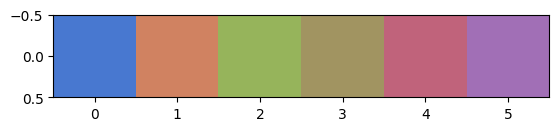

In [8]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

# 定义颜色映射
palette = sns.color_palette('muted')      # 中等饱和度的预定义调色板
colors = [palette[0], palette[1], palette[2], palette[3], palette[4], palette[6]]
cmap = LinearSegmentedColormap.from_list("cmap", colors)

# 创建数据
data = np.array([[0,1,2,3,4,5]], dtype=None)

# 绘制热图
plt.imshow(data, cmap=cmap, vmin=0, vmax=6)
plt.xticks(np.arange(0, data.shape[1], step=1))
plt.show()

# 黏菌的行为模式设计

* 黏菌生活在二维离散的迷宫（培养皿）中，其通过数条伪足探索迷宫试图找到唯一的燕麦
  * 初始化随机但不一定连续的墙柱
* 伪足的产生需要消耗能量，只有成功找到燕麦的伪足不会饿死
 * 假设伪足无法斜向蔓延，以避免三包一时的“穿墙”问题
 * 蔓延速度决定了每一步的蔓延格数
    * 每步的蔓延速度如何对应DFS栈/BFS队列的深度？——每一步只能消耗有限的能量用于`pop()`
* 随着时间推移，呈现 少-广-精 的变化
  * 折线图的纵轴是什么？——占地面积
* More rules
  * 多个黏菌与多个燕麦
  * 黏菌的合作
  * 黏菌本体的死亡


# Custom Color Map

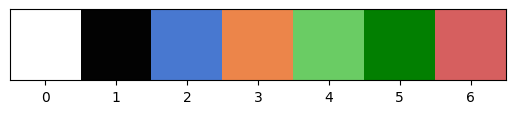

In [123]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# make a custom color map
palette = sns.color_palette('muted')
colors = ["white", "black", palette[0], palette[1], palette[2], "green", palette[3]]
cmap = LinearSegmentedColormap.from_list("cmap", colors)

# make a color dict
color = {
    "white" : 0,
    "black" : 1,
    "blue" : 2,
    "orange" : 3,
    "light_green" : 4,
    "green" : 5,
    "red" : 6
}

# map item to color
item_color = {
    "path" : color["white"],
    "wall" : color["black"],
    "oat" : color["red"],
    "mold" : color["green"],
    "growth" : color["light_green"]
}

# demo
colors_demo = np.arange(7).reshape(1, -1)
draw_params = {'cmap': cmap, 'vmin': 0, 'vmax': 6, 'alpha': 1}

color_path = item_color["path"]
color_wall = item_color["wall"]
color_oat = item_color["oat"]
color_mold = item_color["mold"]
color_growth = item_color["growth"]

# show palette
plt.imshow(colors_demo, cmap=cmap, vmin=0, vmax=6)
plt.xticks(np.arange(0, colors_demo.shape[1], step=1))
plt.yticks([])  # remove y-axis
plt.show()

# Model Implementation 代码实现

In [177]:
#from IPython.display import clear_output
#from time import sleep
#from utils import three_frame
from Cell2D import Cell2D, draw_array

class SlimeMoldForaging(Cell2D):

  def __init__(self, height=19, width=19, max_energy=20, seed=12):
      super().__init__(height, width)
      np.random.seed(seed)  # 统一three_frame()及animate()的可视化结果
      self.height = height
      self.width = width
      self.max_energy = max_energy
      self.maze = np.ones((height, width), dtype=np.int8)  # 迷宫全貌
      self.energy = np.zeros((height, width), dtype=np.int8) # 黏菌蔓延时的剩余能量
      self.start_x = np.random.randint(0, (width // 2)) * 2 + 1
      self.start_y = np.random.randint(0, (height // 2)) * 2 + 1
      self.maze[self.start_y, self.start_x] = 0  # 设置起始点为路径
      self.stack = [(self.start_x, self.start_y)]  # 迷宫生成的DFS栈
      self.queue = []  # 黏菌觅食的BFS队列
      self.action = ""  # 特殊文本命令
      self.path = []
      self.oat_path = []
  
  def place_item(self, item):
      """randomly place item in maze path"""

      # This model only considers a single slime mold searches for a single oat
      if np.any(self.maze == item_color[item]):
          return

      paths = np.argwhere(self.maze == color_path)
      item_coord = paths[np.random.choice(len(paths))]
      self.maze[item_coord[0], item_coord[1]] = item_color[item]

      if item in ["mold", "oat"]:
        item_x, item_y = int(item_coord[1]), int(item_coord[0])
        self.energy[item_x][item_y] = self.max_energy
        if item == "mold":  # preprocess BFS queue
            self.queue.append((item_x, item_y, [(item_x, item_y)]))

  def carve_pathway_step(self):
      """generate paths using DFS"""

      while self.stack:
        x, y = self.stack[-1]
        carve_directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
        np.random.shuffle(carve_directions)
        
        carved = False  # dead end flag to prevent cycle in maze
        for dx, dy in carve_directions:
            nx = x + dx
            ny = y + dy
            if 0 <= nx < self.maze.shape[1] and 0 <= ny < self.maze.shape[0]:
                if self.maze[ny][nx] == color_wall:
                    self.maze[y + dy // 2][x + dx // 2] = 0
                    self.maze[ny][nx] = color_path
                    self.stack.append((nx, ny))
                    carved = True
                    break
        # dead end
        if not carved:
            self.stack.pop()
        
        # special command for steps visualization
        if "step" in self.action:
            break

  def forage_step(self):
      """mold spreads using BFS with energy constraint"""
      while self.queue:
        x, y, path = self.queue.pop(0)
        forage_directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        for dx, dy in forage_directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= ny < self.maze.shape[1] and 0 <= ny < self.maze.shape[0]:
              # pseudopodia keep spreading after find the oat
              if self.maze[ny][nx] in [color_path, color_oat]:
                if self.maze[ny][nx] != color_oat:
                  # consume energy when spreading
                  if self.energy[x][y] > 0:
                    self.maze[ny][nx] = color_growth
                    self.energy[nx][ny] = self.energy[x][y] - 1
                    self.queue.append((nx, ny, path+[(nx, ny)]))
                    self.path.append((nx, ny))
                  else:
                    # stop spreading when energy used out
                    continue
                else:
                    # if reaching oat, recharge energy
                    self.energy[nx][ny] = self.max_energy
                    self.queue.append((nx, ny, path+[(nx, ny)]))
                    self.oat_path.append(path)
        
        # special command for steps visualization
        if "step" in self.action:
            break
        
  def retract_step(self):
    while self.path:
      x, y = self.path.pop()
      if (x, y) in self.oat_path[0]:
        continue

      if self.maze[y][x] == 4:
        self.maze[y][x] = 0
        
      if "step" in self.action:
        break
  
  def find_oat(self):
      """for survival rate calculation"""
      return 1 if self.oat_path else 0
      
  def step(self):
      """model evolves by special text commands in self.progress"""

      if "carve" in self.action:
           self.carve_pathway_step()
      elif "forage" in self.action:
           self.forage_step()
      elif "retract" in self.action:
           self.retract_step()

  def draw(self, nparray="maze"):
      draw_array(getattr(self, nparray), **draw_params)

  def draw_with_energy(self, array=None, annotations=None):
      """port annotate_ca_text(array, annotations) from CA lab2"""

      if array is None:
        array = self.maze
      if annotations is None:
        annotations = self.energy

      rows, cols = array.shape
      ax = plt.gca()

      # Remove minor ticks
      ax.tick_params(which='minor', bottom=False, left=False)

      for i in range(annotations.shape[0]):
        for j in range(annotations.shape[1]):
          ax.text(i, j, str(annotations[i, j]), ha='center', va='center', fontsize=10)

      plt.imshow(array, cmap=cmap, vmin=0, vmax=6, interpolation='none')
      plt.axis('off')
  
  def three_frame(self, n_seq):
    """port three_frame() from utils.py"""
    plt.figure(figsize=(10, 4))

    for i, n in enumerate(n_seq):
      plt.subplot(1, 3, i+1)
      self.loop(n)
      self.draw()

    plt.tight_layout()


# Maze Initialization



## 1.1 Carving Pathway

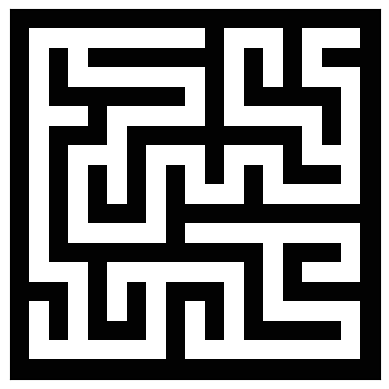

In [179]:
# width and height should preferably be odd nunmbers
env = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)    # seed = 12 has good features in recharge and retraction
env.action = "carve_pathway"
env.step()
env.draw()

## 1.2 Place Mold and Oat

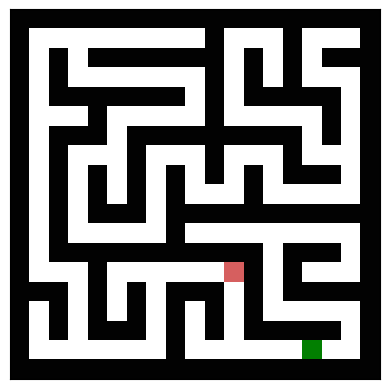

In [180]:
env.place_item("mold")                                                  # present mold in green
env.place_item("oat")                                                   # present oat in red
env.draw()

## 1.3 Progress Visualization

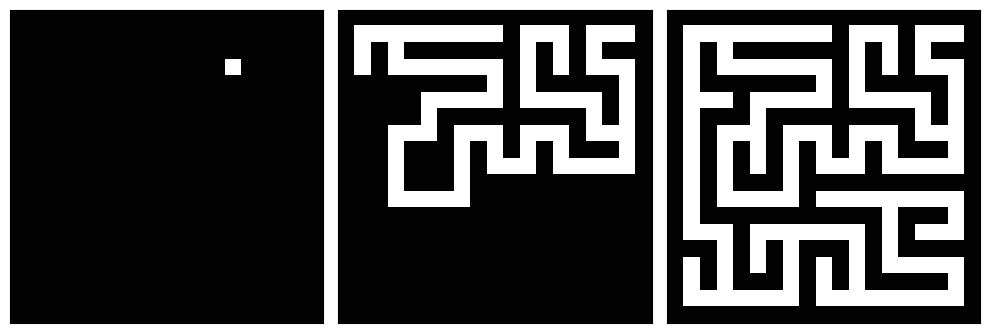

In [181]:
# Pathway carving frames
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway_in_steps"
demo.three_frame([0, 50, 100])                                          # display carving frames at 0, 50 and 150 steps

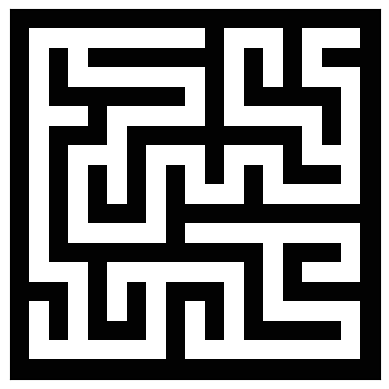

In [182]:
# Pathway carving animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway_in_steps"
demo.animate(frames=150)                                                # show carving animation from step 0 to 150

# Mold Foraging

## 2.1 Mold Foraging

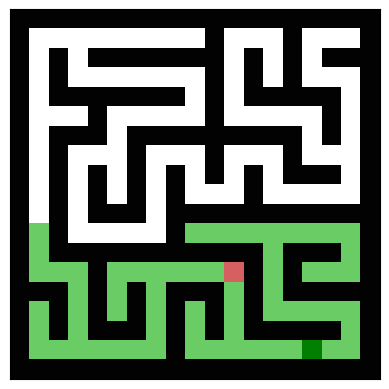

In [183]:
env = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)    # seed = 12 has good features in recharge and retraction
env.action = "carve_pathway"
env.step()
env.place_item("mold")                                                  # present mold in green
env.place_item("oat")                                                   # present oat in red
env.action = "forage"
env.step()
env.draw()

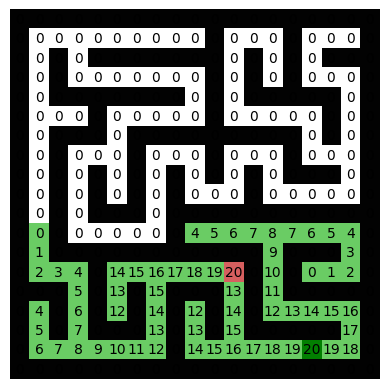

In [184]:
env.draw_with_energy()                                                  # show energy distribution

## 2.2 Progress Visualization

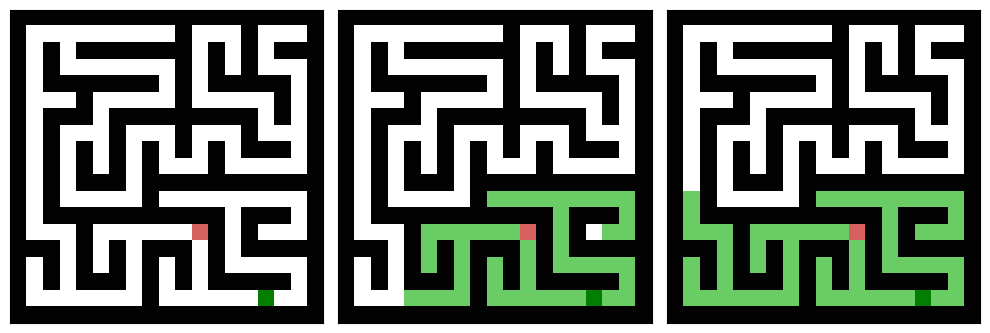

In [185]:
# Foraging frames
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and inactivation
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage_in_steps"
demo.three_frame([0, 50, 100])                                          # display foraging frames at 0, 50 and 150 steps

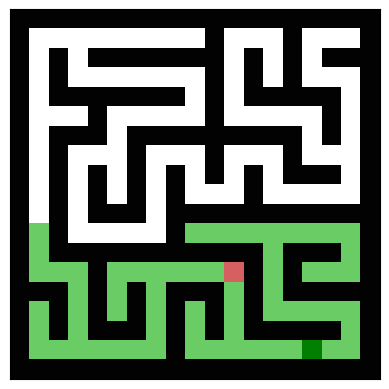

In [186]:
# Foraging animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and inactivation
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage_in_steps"
demo.animate(frames=100)                                                # show foraging animation from step 0 to 100

# Mold Retraction Triggered by Starvation

## 3.1 Mold Retraction

In [194]:
env = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=1)    # seed = 12 has good features in recharge and retraction
# bug: 没找到第一个oat的时候会error -------------------------------^---
env.action = "carve_pathway"
env.step()
env.place_item("mold")                                                  # present mold in green
env.place_item("oat")                                                   # present oat in red
env.action = "forage"
env.step()
env.action = "retract"
env.step()
env.draw()

IndexError: list index out of range

## 3.2 Progress Visualization

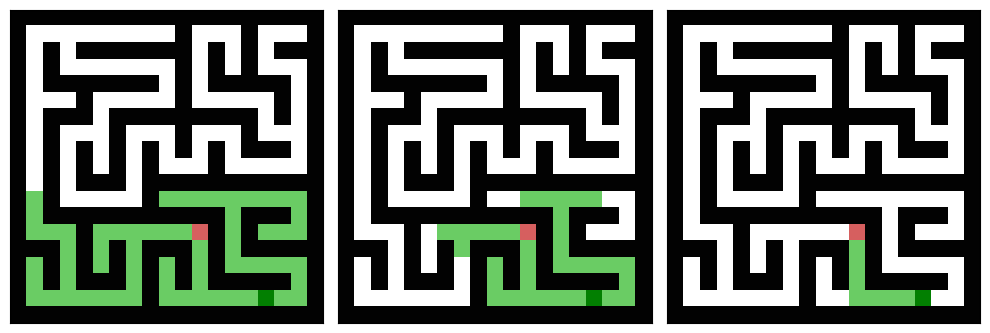

In [188]:
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)    # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                  # present mold in green
demo.place_item("oat")                                                   # present oat in red
demo.action = "forage"
demo.step()                                                              # present oat in red
demo.action = "retract_in_steps"
demo.three_frame([0, 30, 30])                                            # display retraction frames at 0, 30 and 60 steps

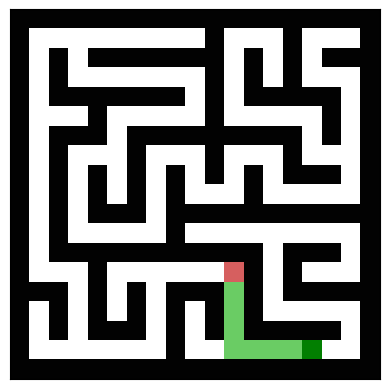

In [189]:
# Foraging animation
demo = SlimeMoldForaging(height=19, width=19, max_energy=20, seed=12)   # seed = 12 has good features in recharge and retraction
demo.action = "carve_pathway"
demo.step()
demo.place_item("mold")                                                 # present mold in green
demo.place_item("oat")                                                  # present oat in red
demo.action = "forage"
demo.step()                                                    
demo.action = "retract_in_steps"
demo.animate(frames=60)                                                # show foraging animation from step 0 to 100

# Survival Rate Curve

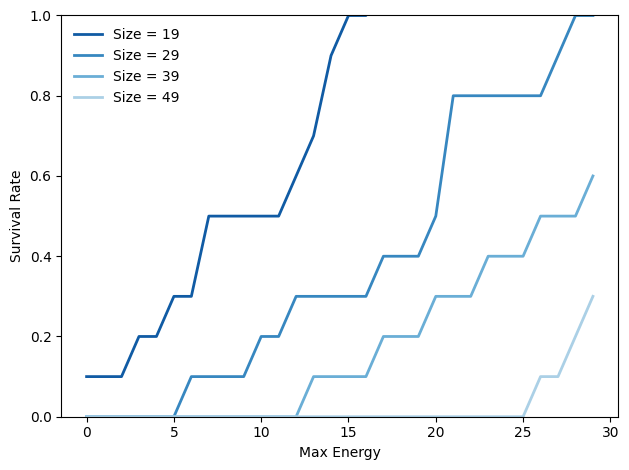

In [192]:
from utils import set_palette, decorate
set_palette('Blues', 5, reverse=True)

for p in [19,29,39,49]:
    segs = []
    for energy in range(30):
        is_find = 0
        for seeds in range(50):
            demo = SlimeMoldForaging(height=p, width=p, max_energy=energy, seed=seeds)
            demo.action = "carve_pathway"
            demo.step()
            demo.place_item("mold")
            demo.place_item("oat")
            demo.action = "forage"
            demo.step()     
            is_find += demo.find_oat()
        p_find = is_find / 10
        segs.append(p_find)
    plt.plot(segs, label='Size = %d' % p)
    
decorate(xlabel='Max Energy', ylabel='Survival Rate', loc='best', ylim=[0, 1])


# Development Logs

> 5 Oct, 2024
* Begin logging
* Introduce energy constraint in `forage_step()`
  * Add `energy: np.ndarray` as energy map of maze
* Add `draw_with_energy()` to visualize energy loss when foraging
  * Swap the index of `'green'` and `'light_green'` in **Custom Color Map**
* Unify random seeds for visualiazation to achieve reliable reproduction

> 6 Oct, 2024
* Update **Setup**
  * Add `!pip install scipy` for the local execution of cross-correlation principle
* Git-based multiple cooperation
  * Init logs there
  * Unify variable naming style between `carve_pathway_step` and `forage_step()`

> 7 Oct, 2024
* Port `three_frame()` from `utils.py`
* Update **Setup**
  * Remove redundant `mkdir` in **Setup**
* Add `die_step()`
* Add **Survival Rate Curve**

> 8 Oct, 2024
* Add markdown subtitles and format them
* Rename `die_step()` -> `retract_step`
* Remove `!pip install scipy` in **Setup**

> Todo List
* Remove `NumPy Array Quick Reviews`
* Add function comments before submission